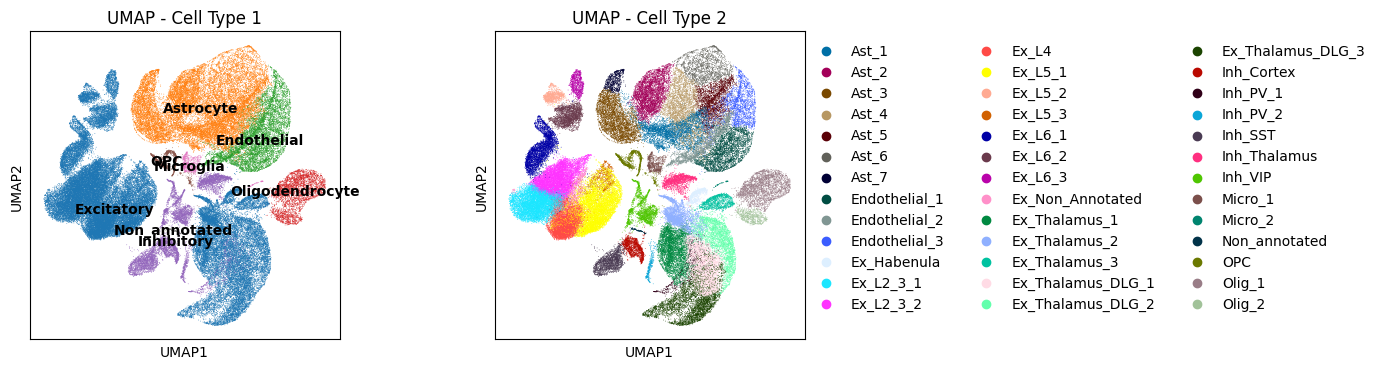

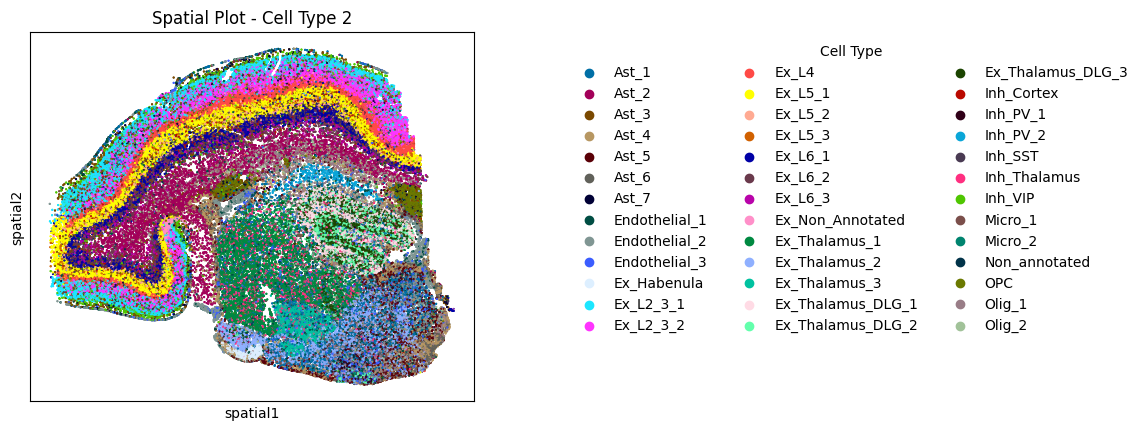

In [1]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import Layout
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.display import display, FileLink
import warnings
warnings.filterwarnings('ignore')

# read the data
adata = sc.read_h5ad('P4_marmoset_test_brain.hdf5')
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
cluster_options = sorted(list(adata.obs['cell_type_2'].unique()))

# Cell Type 1 & 2　UMAP
ncols = 2
nrows = 1
figsize = 4
wspace = 0.5
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize),
)
plt.subplots_adjust(wspace=wspace)

sc.pl.umap(adata, color=["cell_type_1"], legend_loc="on data", title='UMAP - Cell Type 1', ax=axs[0], show=False)

sc.pl.umap(adata, color=["cell_type_2"], title='UMAP - Cell Type 2',  ax=axs[1], show=False)
axs[1] = plt.gca()
handles, labels = axs[1].get_legend_handles_labels()
labels_sorted, handles_sorted = zip(*sorted(zip(labels, handles)))
axs[1].legend(handles_sorted, labels_sorted, loc='upper right', bbox_to_anchor=(2.85, 1), ncol=3, frameon=False)
plt.show()

# Cell Type 2　spatial plot
sq.pl.spatial_scatter(adata, shape=None, color=["cell_type_2"], title='Spatial Plot - Cell Type 2')
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
labels_sorted, handles_sorted = zip(*sorted(zip(labels, handles)))
ax.legend(handles_sorted, labels_sorted, loc='upper right', bbox_to_anchor=(2.5, 1), ncol=3, title='Cell Type', frameon=False)
plt.show()


# widget
cluster_options = sorted(list(adata.obs['cell_type_2'].unique()))

clusters_widget_A = widgets.SelectMultiple(
    options=cluster_options,
    description='Clusters A:',
    layout=Layout(height='200px')
)

clusters_widget_B = widgets.SelectMultiple(
    options=cluster_options,
    description='Clusters B:',
    layout=Layout(height='200px')
)

button_run_analysis = widgets.Button(
    description="Run Analysis"
)

button_save_png = widgets.Button(
    description="Save Plot"
)

button_save_csv = widgets.Button(
    description="Save CSV"
)

output = widgets.Output()

def on_button_clicked(b):
    with output:
        output.clear_output()
        selected_clusters_A = list(clusters_widget_A.value)
        selected_clusters_B = list(clusters_widget_B.value)
        
        if selected_clusters_A and selected_clusters_B:
            # make new selected clusters
            merged_cluster_A = '_'.join(selected_clusters_A)
            merged_cluster_B = '_'.join(selected_clusters_B)
            
            # label the new selected clusters
            adata.obs['cell_type_3'] = adata.obs['cell_type_2']
            adata.obs['cell_type_3'] = adata.obs['cell_type_3'].astype(str)
            adata.obs['cell_type_3'][adata.obs['cell_type_3'].isin(selected_clusters_A)] = merged_cluster_A
            adata.obs['cell_type_3'][adata.obs['cell_type_3'].isin(selected_clusters_B)] = merged_cluster_B
            
            # categorical
            adata.obs['cell_type_3'] = adata.obs['cell_type_3'].astype('category')
 
            # wilcoxon rank test
            sc.tl.rank_genes_groups(adata, 'cell_type_3', groups=[merged_cluster_A], reference=merged_cluster_B, method='wilcoxon')
            
            # scanpy rank plot
            sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
        else:
            print("Please select clusters.")

def on_save_plot_button_clicked(b):
    with output:
        output.clear_output()
        
        # save plot
        sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, show=False)
        plt.savefig('C:/Users/kohei/Downloads/rank_genes_groups_plot.png', dpi=300, bbox_inches='tight')
        
        print(f"Plot saved to Downloads folder")
        
def on_save_csv_button_clicked(b):
    with output:
        output.clear_output()
        
        if 'rank_genes_groups' in adata.uns:
            # data frame
            result = adata.uns['rank_genes_groups']
            groups = result['names'].dtype.names
            
            dfs = []
            for group in groups:
                df = pd.DataFrame({
                    'gene': result['names'][group],
                    'logfoldchanges': result['logfoldchanges'][group],
                    'pvals': result['pvals'][group],
                    'pvals_adj': result['pvals_adj'][group]
                })
                df['group'] = group
                dfs.append(df)
            
            # save dataframe as csv
            result_df = pd.concat(dfs, axis=0)
            result_df.to_csv('C:/Users/kohei/Downloads/differential_expression.csv', index=False)
            print(f"Results saved to Downloads folder")
        else:
            print("No results to save. Please run the analysis first.")

button_run_analysis.on_click(on_button_clicked)
button_save_png.on_click(on_save_plot_button_clicked)
button_save_csv.on_click(on_save_csv_button_clicked)

display(widgets.VBox([
    widgets.HBox([clusters_widget_A, clusters_widget_B]),
    button_run_analysis,
    widgets.HBox([button_save_png, button_save_csv]),
    output
]))

In [6]:
print("Select Clusters for plotting Spatial Scatter")
clusters_spatial_widget = widgets.SelectMultiple(
    options=cluster_options,
    description='Clusters:',
    layout=Layout(height='200px')
)

button_spatial_plot = widgets.Button(
    description="Spatial plot"
)

output = widgets.Output()

def on_spatial_scatter(b):
    with output:
        output.clear_output()
        selected_spatial_clusters = list(clusters_spatial_widget.value)
        
        adata.obs['cell_type_spatial'] = adata.obs['cell_type_2']
        adata.obs['cell_type_spatial'] = adata.obs['cell_type_spatial'].astype(str)
        adata.obs['cell_type_spatial'][~adata.obs['cell_type_spatial'].isin(selected_spatial_clusters)] = 'other cell type'
        adata.obs['cell_type_spatial'] = adata.obs['cell_type_spatial'].astype('category')
        
        categories = adata.obs['cell_type_2'].cat.categories
        category_colors = dict(zip(categories, adata.uns['cell_type_2_colors']))
        new_categories = adata.obs['cell_type_spatial'].cat.categories
        new_category_colors = {cat: category_colors[cat] if cat in category_colors else '#f8f9fa' for cat in new_categories}
        custom_cmap = mcolors.ListedColormap([new_category_colors[key] for key in new_category_colors])

        sq.pl.spatial_scatter(adata, shape=None, color="cell_type_spatial", size=5, figsize=[10,10], palette=custom_cmap, title='Cell Type 2 Spatial Plot')
        plt.show()
        
button_spatial_plot.on_click(on_spatial_scatter)

display(widgets.VBox([
    widgets.HBox([clusters_spatial_widget]),
    widgets.HBox([button_spatial_plot]),
    output
]))

Select Clusters for plotting Spatial Scatter


In [8]:
# widget
gene_options = adata.var.index.tolist()

gene_widget = widgets.SelectMultiple(
    options=gene_options,
    description='Gene:',
    layout=Layout(height='200px')
)

button_dot_plot = widgets.Button(
    description="Dot plot"
)

button_violin_plot = widgets.Button(
    description="Violin plot"
)

button_feature_plot = widgets.Button(
    description="Feature plot"
)

button_spatialfeature_plot = widgets.Button(
    description="Spatial Feature plot"
)

output = widgets.Output()

def on_button_dotplot(b):
    with output:
        output.clear_output(wait=True)
        selected_gene = list(gene_widget.value)
        sc.pl.dotplot(adata, selected_gene, 'cell_type_2', dendrogram=False, categories_order=sorted(adata.obs['cell_type_2'].unique()))

    return 0

def on_button_violinplot(b):
    with output:
        output.clear_output(wait=True)
        selected_gene = list(gene_widget.value)
        sc.pl.stacked_violin(adata, selected_gene, 'cell_type_2', dendrogram=False, categories_order=sorted(adata.obs['cell_type_2'].unique()))

    return 0

def on_button_featureplot(b):
    with output:
        output.clear_output(wait=True)
        selected_gene = list(gene_widget.value)
        selected_gene.append('cell_type_2')
        sc.pl.umap(adata, color=selected_gene, ncols=4)

    return 0

def on_button_spatialfeatureplot(b):
    with output:
        output.clear_output(wait=True)
        selected_gene = list(gene_widget.value)
        sq.pl.spatial_scatter(adata, color=selected_gene, shape=None, size=1, img=False, cmap='Purples', ncols=4)
        plt.show()
        
    return 0

button_dot_plot.on_click(on_button_dotplot)
button_violin_plot.on_click(on_button_violinplot)
button_feature_plot.on_click(on_button_featureplot)
button_spatialfeature_plot.on_click(on_button_spatialfeatureplot)

display(widgets.VBox([
    widgets.HBox([gene_widget]),
    widgets.HBox([button_dot_plot, button_violin_plot, button_feature_plot, button_spatialfeature_plot]),
    output
]))